# Context
In this notebook we perform anomaly detection as described in IWSHM paper (PBSHM) . zero shot anomaly detection using a classifier

In [5]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 14

In [175]:


import tensorflow as tf
from datetime import datetime
from PBSHM_mdof.data.formatting import format_data
from PBSHM_mdof.models.classification.dense_nn import DenseSignalClassifier, get_loss

import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import mlflow
import mlflow.keras
import pandas as pd
import seaborn as sns
from PBSHM_mdof.models.utils import plot_control_chart, plot_control_chart_latent , compute_auc_df
from PBSHM_mdof.data.utils import data_name_SNR_nperseg
#%%
# Load and format the data
snr = 10 
nperseg= 1024


data_name = data_name_SNR_nperseg(snr,nperseg)

df, labels, index_train, index_test, transformer = format_data(test_size=0.5,data_name=data_name)
psds_test = np.stack(df.loc[index_test]['psd'].values)
psds_train = np.stack(df.loc[index_train]['psd'].values)

system_id_test = labels[index_test]
system_id_train = labels[index_train]

num_class = system_id_train.shape[-1]
system_name = (df['system_name'].unique()).tolist()
system_name.sort(key=lambda x:x[-2:])

# Log variable values to MLflow
latent_std = np.around(df['latent_value'].std())
latent_mean = np.around(df['latent_value'].mean())
training_size = len(index_train/num_class)
heterogenity = 0
loss_function = 'categorical_crossentropy'
layers =[512, 256,128, 64, 32,20]
optimizer = 'adam'
dropout_rate = 0
model = "DenseSignalClassifier"
activation = 'ReLU'
batch_norm = True
l1_reg = 0.0001
# prepare dataframe for plotting
#%%
df['type']= 'test'
df.loc[index_train, 'type'] = 'train'
df_result = df[['system_name','anomaly_level','state','latent_value','type']]


# Start MLflow run
df_result['anomaly_level'] = df_result['anomaly_level'].astype('float')
df_result['type'][(df_result['anomaly_level'] ==0)& (df_result['type'] == 'test')]='validation'

df['anomaly_level'] = df['anomaly_level'].astype('float')
df['type'][(df['anomaly_level'] ==0)& (df['type'] == 'test')]='validation'


INFO:root:No NaN values in PSDs
INFO:root:Number of experiments in train set for system_9: 600
INFO:root:Number of experiments in train set for system_15: 600
INFO:root:Number of experiments in train set for system_18: 600
INFO:root:Number of experiments in train set for system_19: 600
INFO:root:Number of experiments in train set for system_17: 600
INFO:root:Number of experiments in train set for system_2: 600
INFO:root:Number of experiments in train set for system_8: 600
INFO:root:Number of experiments in train set for system_6: 600
INFO:root:Number of experiments in train set for system_1: 600
INFO:root:Number of experiments in train set for system_11: 600
INFO:root:Number of experiments in train set for system_12: 600
INFO:root:Number of experiments in train set for system_7: 600
INFO:root:Number of experiments in train set for system_16: 600
INFO:root:Number of experiments in train set for system_13: 600
INFO:root:Number of experiments in train set for system_4: 600
INFO:root:Numbe

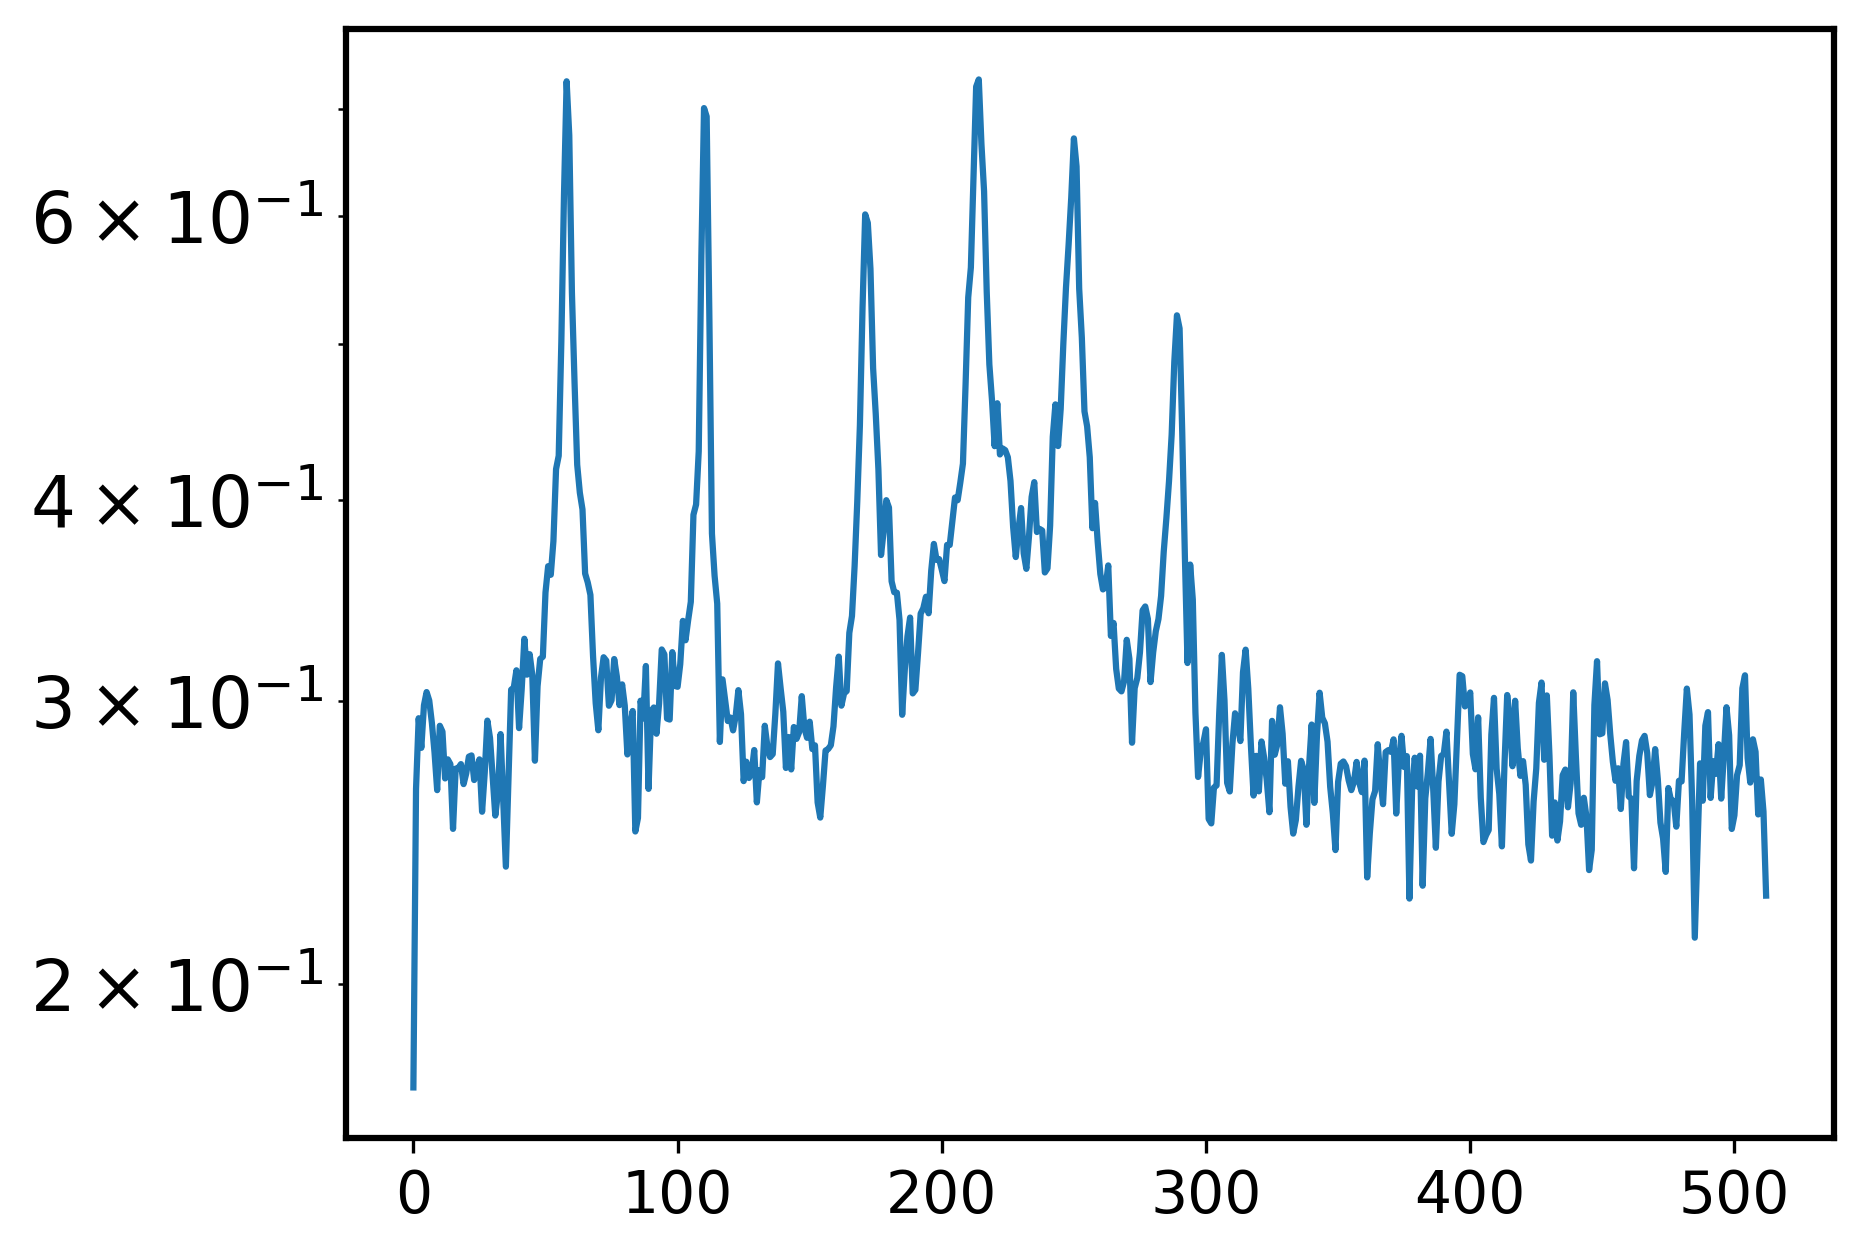

In [201]:
plt.plot(psds_train[0])
plt.yscale('log')

In [176]:
# Instantiate the model

In [177]:
model_ = eval(model)(inputDim=(psds_train[0].shape[-1]),
                                num_class=system_id_train.shape[-1],
                                dense_layers=layers,
                                dropout_rate=dropout_rate,
                                batch_norm=batch_norm,
                                activation=activation,
                                l1_reg=l1_reg
                                )

In [178]:
model_=model_.build_model(optimizer=optimizer)


In [179]:
path_model = f'../data/models/snr_{snr}/nperseg_{nperseg}/model_IWSMH.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=path_model,
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                    factor=0.5, 
                                                    patience=5, 
                                                    min_lr=1e-6)

In [180]:
# Train the model and log the results

In [202]:
model_.fit(psds_train, system_id_train, epochs=100, batch_size=64,verbose=1,validation_split=0.2,
              callbacks=[early_stopping_callback,reduce_lr,model_checkpoint_callback])
best_model = tf.keras.models.load_model(path_model,
                                             custom_objects={'DenseSignalClassifier': DenseSignalClassifier, 
                                                             'loss_fn': get_loss(temperature=1)})

Epoch 1/100
147/150 [============================>.] - ETA: 0s - loss: 2.1765 - accuracy: 0.9956
Epoch 1: val_loss improved from 2.41374 to 2.19441, saving model to ../data/models/snr_10/nperseg_1024/model_IWSMH.h5
150/150 [==============================] - 1s 6ms/step - loss: 2.1765 - accuracy: 0.9956 - val_loss: 2.1944 - val_accuracy: 0.9846 - lr: 1.2500e-04
Epoch 2/100
147/150 [============================>.] - ETA: 0s - loss: 2.1658 - accuracy: 0.9974
Epoch 2: val_loss improved from 2.19441 to 2.16545, saving model to ../data/models/snr_10/nperseg_1024/model_IWSMH.h5
150/150 [==============================] - 1s 6ms/step - loss: 2.1656 - accuracy: 0.9975 - val_loss: 2.1654 - val_accuracy: 0.9946 - lr: 1.2500e-04
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 2.1572 - accuracy: 0.9981
Epoch 3: val_loss did not improve from 2.16545
150/150 [==============================] - 1s 5ms/step - loss: 2.1572 - accuracy: 0.9981 - val_loss: 2.1782 - val_accuracy: 0.9767

In [182]:
# Compute the confidences of the classidication for the data

In [183]:
score = best_model.predict(np.stack(df['psd'].values))
true_class = np.argmax(labels, axis=1)
predicted_class = np.argmax(score, axis=1)
confidence=score[np.arange(len(true_class)), true_class]

1625/1625 [==============================] - 2s 1ms/step


In [184]:
df_result['confidence'] = confidence

/tmp/ipykernel_52790/1541609246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['confidence'] = confidence


In [185]:
# Compute the AUC for the data  using the confidence estimated through the softmax layer of the model as 
# the anomaly score (estimate of the probability of the data to be normal)

In [186]:
compute_auc_df(df_result,col_name='confidence')

,system_0,system_1,system_2,system_3,system_4,system_5,system_6,system_7,system_8,system_9,system_10,system_11,system_12,system_13,system_14,system_15,system_16,system_17,system_18,system_19
auc_0.0,0.505,0.512,0.487,0.481,0.493,0.527,0.484,0.495,0.513,0.509,0.476,0.513,0.529,0.535,0.475,0.521,0.488,0.487,0.495,0.489
auc_0.01,0.505,0.508,0.514,0.526,0.494,0.536,0.451,0.455,0.484,0.466,0.51,0.568,0.559,0.502,0.555,0.503,0.465,0.564,0.564,0.545
auc_0.03,0.556,0.569,0.524,0.538,0.444,0.491,0.301,0.425,0.483,0.421,0.397,0.592,0.619,0.503,0.571,0.476,0.38,0.669,0.662,0.701
auc_0.05,0.567,0.624,0.538,0.503,0.473,0.397,0.229,0.368,0.426,0.392,0.337,0.654,0.685,0.547,0.661,0.508,0.31,0.703,0.731,0.805
auc_0.07,0.599,0.702,0.563,0.538,0.414,0.445,0.151,0.347,0.465,0.386,0.269,0.65,0.735,0.571,0.685,0.485,0.252,0.766,0.793,0.883
auc_0.09,0.594,0.774,0.63,0.591,0.392,0.443,0.073,0.38,0.528,0.385,0.19,0.724,0.768,0.597,0.764,0.485,0.196,0.846,0.826,0.942
auc_0.11,0.632,0.831,0.623,0.601,0.42,0.373,0.052,0.369,0.536,0.316,0.136,0.771,0.781,0.573,0.812,0.505,0.135,0.866,0.853,0.96
auc_0.13,0.636,0.879,0.696,0.702,0.376,0.47,0.048,0.402,0.65,0.333,0.095,0.815,0.744,0.659,0.857,0.463,0.123,0.932,0.887,0.972


In [187]:
# compute the encoding of the data using the best model
psds_validation = np.stack(df.loc[df['type']=='validation']['psd'].values)
embedding=best_model.layers[1].call_encoder_penultimate(psds_validation)

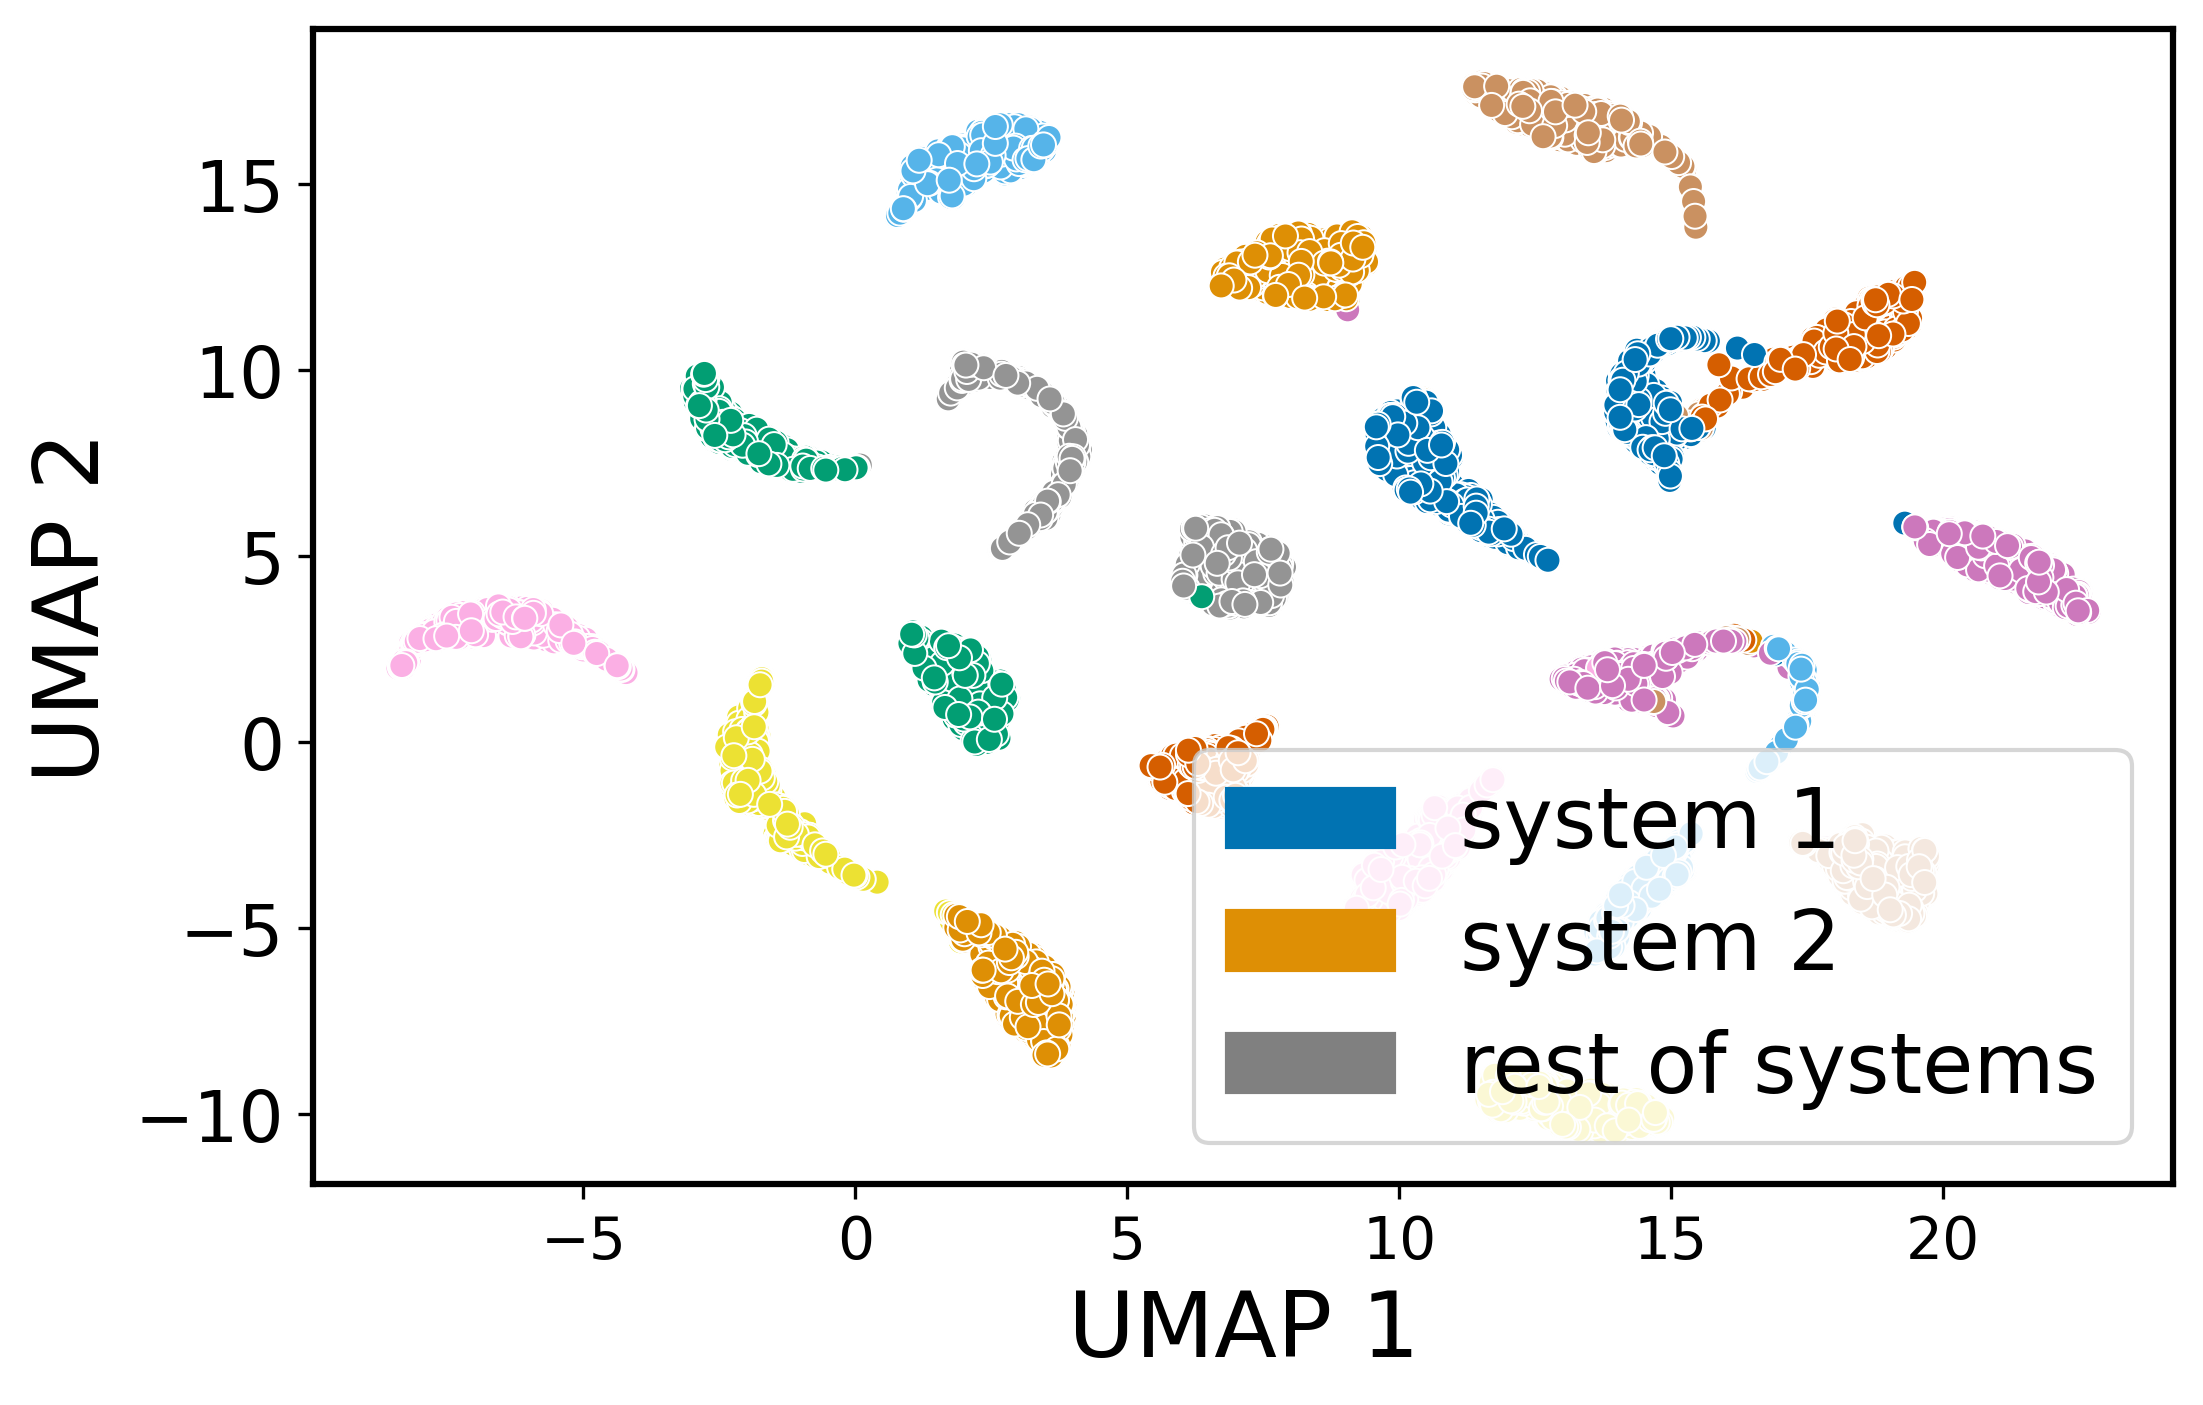

In [188]:
# Using UMAP to visualize the latent space
import umap
reducer = umap.UMAP()
embedding_emb = reducer.fit_transform(embedding)

import seaborn as sns
cm = sns.color_palette('colorblind', n_colors=20)

# Create a custom legend for the first two colors
legend_dict = {'system 1': cm[0], 'system 2': cm[1], 'rest of systems': 'gray'}

# Add a third line to the legend indicating the number of additional systems


fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(x=embedding_emb[:,0], y=embedding_emb[:,1], hue=df.loc[df['type']=='validation']['system_name'], palette=cm, ax=ax)

# Add the custom legend to the plot
ax.legend(handles=[plt.Rectangle((0,0),1,1, color=val) for key, val in legend_dict.items()], labels=legend_dict.keys(), fontsize=20,loc='lower right')

ax.set_xlabel('UMAP 1', fontsize=22)
ax.set_ylabel('UMAP 2', fontsize=22)
fig.savefig('../docs/umap1.png', dpi=300, bbox_inches='tight')


In [189]:
# visualize the latent space using pca 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embedding_pca = pca.fit_transform(embedding)


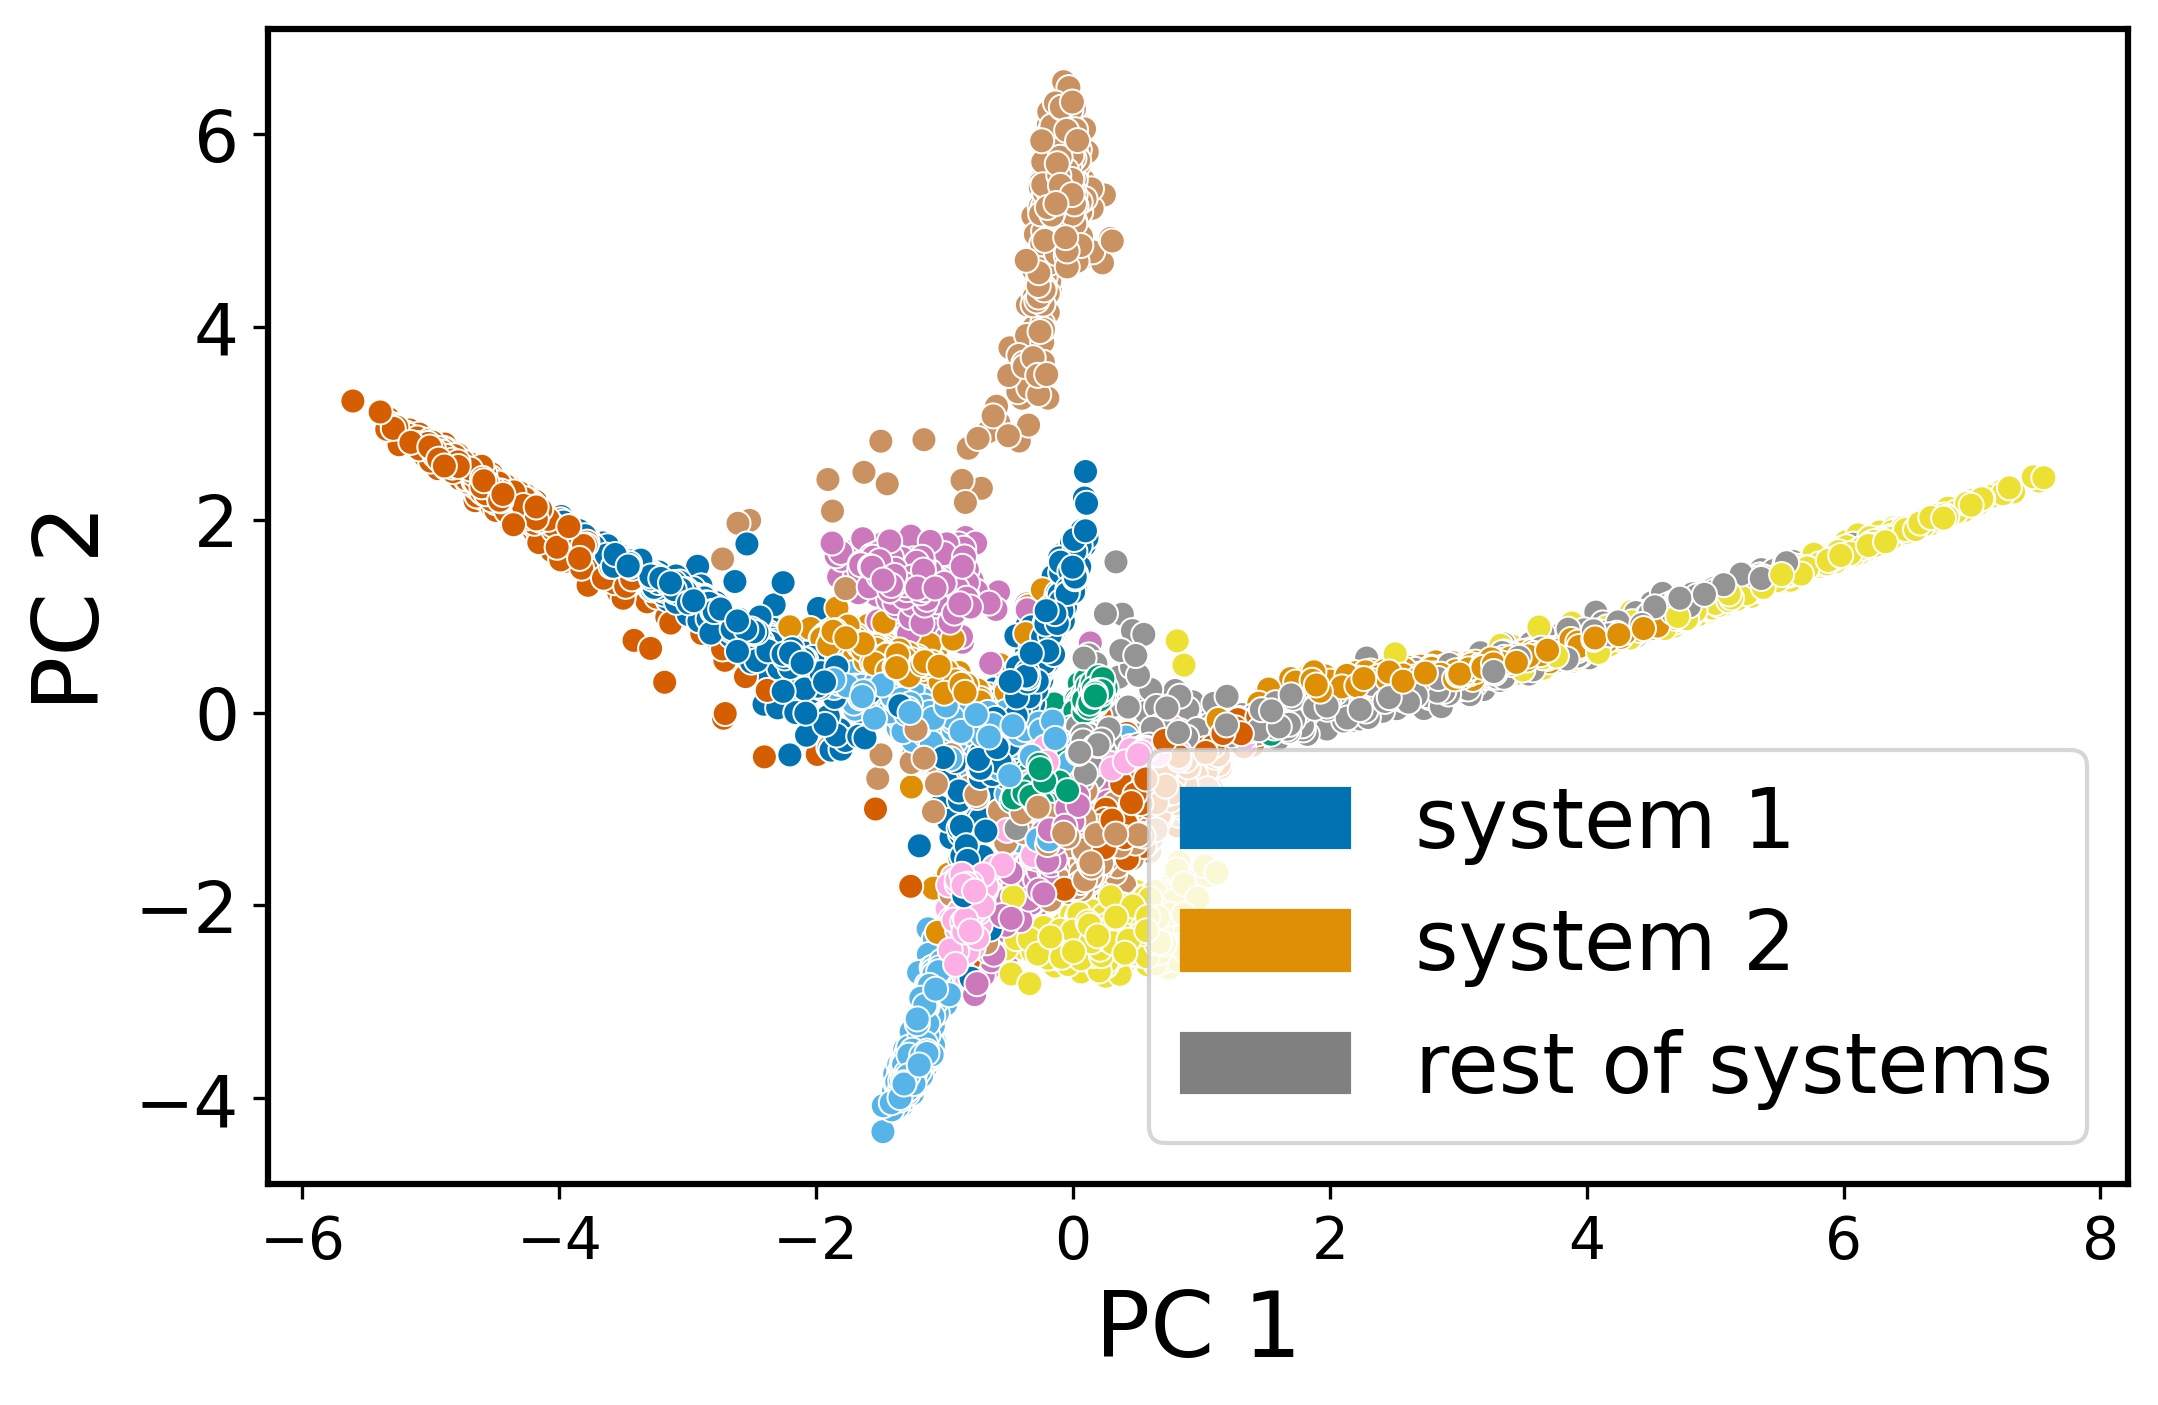

In [190]:
import seaborn as sns
cm = sns.color_palette('colorblind', n_colors=20)

# Create a custom legend for the first two colors
legend_dict = {'system 1': cm[0], 'system 2': cm[1], 'rest of systems': 'gray'}

# Add a third line to the legend indicating the number of additional systems


fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(x=embedding_pca[:,0], y=embedding_pca[:,1], hue=df.loc[df['type']=='validation']['system_name'], palette=cm, ax=ax)

# Add the custom legend to the plot
ax.legend(handles=[plt.Rectangle((0,0),1,1, color=val) for key, val in legend_dict.items()], labels=legend_dict.keys(), fontsize=20,loc='lower right')

ax.set_xlabel('PC 1', fontsize=22)
ax.set_ylabel('PC 2', fontsize=22)
fig.savefig('../docs/pca.png', dpi=300, bbox_inches='tight')

In [191]:
#fit a gaussian mixture model to the data

from sklearn.mixture import GaussianMixture
psd_train = np.stack(df.loc[df['type']=='train']['psd'].values)
embedding=best_model.layers[1].call_encoder_penultimate(psd_train)
gmm = GaussianMixture(n_components=2).fit(embedding)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f1fa4cb1e10>
Traceback (most recent call last):
  File "/home/yacine/miniconda3/envs/PBSHM_mdofenv/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/yacine/miniconda3/envs/PBSHM_mdofenv/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/yacine/miniconda3/envs/PBSHM_mdofenv/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/yacine/miniconda3/envs/PBSHM_mdofenv/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [192]:
psd_all = np.stack(df['psd'].values)
model__= best_model.layers[1]
embedding_all=best_model.layers[1].call_encoder_penultimate(psd_all)
score = gmm.score_samples(embedding_all)

In [193]:
df_result['gmm-score'] = score

/tmp/ipykernel_52790/697320535.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['gmm-score'] = score


In [194]:
def compute_auc_df(df,col_name='confidence'):
    system_name = df['system_name'].unique().tolist()
    system_name.sort(key=lambda x: int(x.split('_')[-1]))
    anomaly_level = np.sort(df['anomaly_level'].unique())
    auc_df = pd.DataFrame(columns=system_name)
    for system_id in system_name:
        healthy_training_data = df[col_name][(df['system_name'] == system_id) & (df['type'] == 'train')]
        healthy_testing_data = df[col_name][(df['system_name'] == system_id) & (df['type'] == 'validation')]
      
        
        for al in anomaly_level:
            if al == 0:
                assert len(healthy_training_data) == len(healthy_testing_data)
                auc = compute_auc(healthy_training_data, healthy_testing_data)
            else:
                anomaly_data = df[col_name][(df['system_name'] == system_id) & (df['type'] == 'test') & (df['anomaly_level'] == al)]
                healthy_testing_data = df[col_name][(df['system_name'] == system_id) & (df['type'] == 'validation')].iloc[-len(anomaly_data):]
                assert len(anomaly_data) == len(healthy_testing_data)
                auc = compute_auc(healthy_testing_data, anomaly_data)
            auc_df.loc[f'auc_{al}', system_id] = auc
    return auc_df

In [195]:
compute_auc_df(df_result,col_name='gmm-score')


,system_0,system_1,system_2,system_3,system_4,system_5,system_6,system_7,system_8,system_9,system_10,system_11,system_12,system_13,system_14,system_15,system_16,system_17,system_18,system_19
auc_0.0,0.514,0.493,0.51,0.512,0.529,0.548,0.486,0.533,0.544,0.512,0.545,0.482,0.476,0.506,0.509,0.463,0.521,0.534,0.514,0.505
auc_0.01,0.504,0.507,0.517,0.498,0.47,0.496,0.57,0.486,0.517,0.523,0.509,0.511,0.448,0.549,0.539,0.554,0.553,0.422,0.493,0.474
auc_0.03,0.508,0.542,0.546,0.444,0.522,0.407,0.673,0.461,0.626,0.615,0.551,0.52,0.384,0.574,0.543,0.626,0.569,0.347,0.407,0.463
auc_0.05,0.509,0.61,0.562,0.48,0.407,0.408,0.699,0.463,0.68,0.634,0.632,0.491,0.351,0.55,0.595,0.636,0.603,0.429,0.363,0.45
auc_0.07,0.555,0.688,0.654,0.559,0.497,0.523,0.828,0.515,0.789,0.782,0.773,0.566,0.393,0.616,0.654,0.701,0.722,0.57,0.385,0.432
auc_0.09,0.595,0.733,0.701,0.647,0.505,0.612,0.912,0.541,0.841,0.845,0.877,0.609,0.41,0.659,0.749,0.776,0.779,0.72,0.457,0.393
auc_0.11,0.603,0.751,0.751,0.694,0.475,0.632,0.944,0.527,0.91,0.904,0.928,0.697,0.502,0.738,0.825,0.829,0.811,0.79,0.494,0.417
auc_0.13,0.695,0.725,0.838,0.794,0.497,0.706,0.947,0.623,0.959,0.96,0.949,0.791,0.588,0.796,0.887,0.892,0.865,0.855,0.646,0.429


In [197]:
compute_auc_df(df_result,col_name='gmm-score').mean(axis=1)


auc_0.0     0.512
auc_0.01    0.507
auc_0.03    0.516
auc_0.05    0.528
auc_0.07    0.610
auc_0.09    0.668
auc_0.11    0.711
auc_0.13    0.772
dtype: float64

In [99]:
col_name = 'gmm-score'
system_id = 'system_1'
healthy_testing_data = df_result[col_name][(df_result['system_name'] == system_id) & (df_result['type'] == 'validation')]


In [100]:
((df_result['system_name'] == system_id)  & (df_result['type'] == 'validation')).sum()

600

In [101]:
df_result['gmm-score'] = df_result['gmm-score'] + 0.5

/tmp/ipykernel_52790/4011517232.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['gmm-score'] = df_result['gmm-score'] + 0.5


In [102]:
# min max scale the gmm score
df_result['gmm-score'] = (df_result['gmm-score'] - 0.8)/(1 - 0.8)

/tmp/ipykernel_52790/4205602470.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['gmm-score'] = (df_result['gmm-score'] - 0.8)/(1 - 0.8)


In [103]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
def plot_control_chart(df,system_id, column='confidence', ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    data_system = df[df['system_name'] == system_id]
    df_train = data_system[data_system['type'] == 'train']
    df_test = data_system[data_system['type'] == 'test']
    df_test= df_test.sort_values(by='anomaly_level', ascending=True)

    df_plot = pd.concat([df_train, df_test])
    df_plot.reset_index(inplace=True)
    #df_plot[column]=df_plot[column].rolling(10).apply(lambda x:np.prod(x))
    ax.plot(df_plot.index, df_plot[column], marker='.', linestyle='')
    anomaly_level=df_plot[df_plot['anomaly_level'].astype(float).diff()!=0]['anomaly_level'].to_dict()

    y_lowbound, y_upbound= ax.get_ylim()
    middle = (y_lowbound + y_upbound) / 2
    range = (y_upbound - y_lowbound) / 2
    text_y = middle - range * 0.9


    ax.axvline(x=len(df_train), color='firebrick', linestyle='--', alpha=0.5)
    #ax.text(len(df_train), text_y, 'test data', rotation=90, color='firebrick', alpha=0.9)
    for key in list(anomaly_level.keys())[1:]:
        ax.axvline(x=key, color='firebrick', linestyle='--', alpha=0.5)
        ax.text(key, text_y, anomaly_level[key], color='black', alpha=1,rotation=90)

    mean = np.mean(df_plot.iloc[:len(df_train)][column])
    std = np.std(df_plot.iloc[:len(df_train)][column])
    lcl = mean - 2 * std
    ax.plot()
    ax.axhline(y=lcl, color='firebrick', linestyle='--', alpha=0.5)
    ax.text(0, lcl-0.2*range, 'LCL', rotation=0, color='firebrick', alpha=0.9)
    # coloring out of control data with red 
    allert_df = df_plot[df_plot[column] < lcl]
    ax.plot(allert_df.index, allert_df[column], marker='.', linestyle='', color='red')

    ax.set_ylabel(column)
    ax.set_xlabel('index')
    ax.set_title(system_id)
    return  ax


In [105]:
sys = 'system_17'
df_sys = df_result[df_result['system_name'] == sys]
min = df_sys['gmm-score'].quantile(0.01)
max = df_sys['gmm-score'].quantile(0.99)
df_result['gmm-score'] = (df_result['gmm-score'] - min)/(max - min)

/tmp/ipykernel_52790/1178018016.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['gmm-score'] = (df_result['gmm-score'] - min)/(max - min)


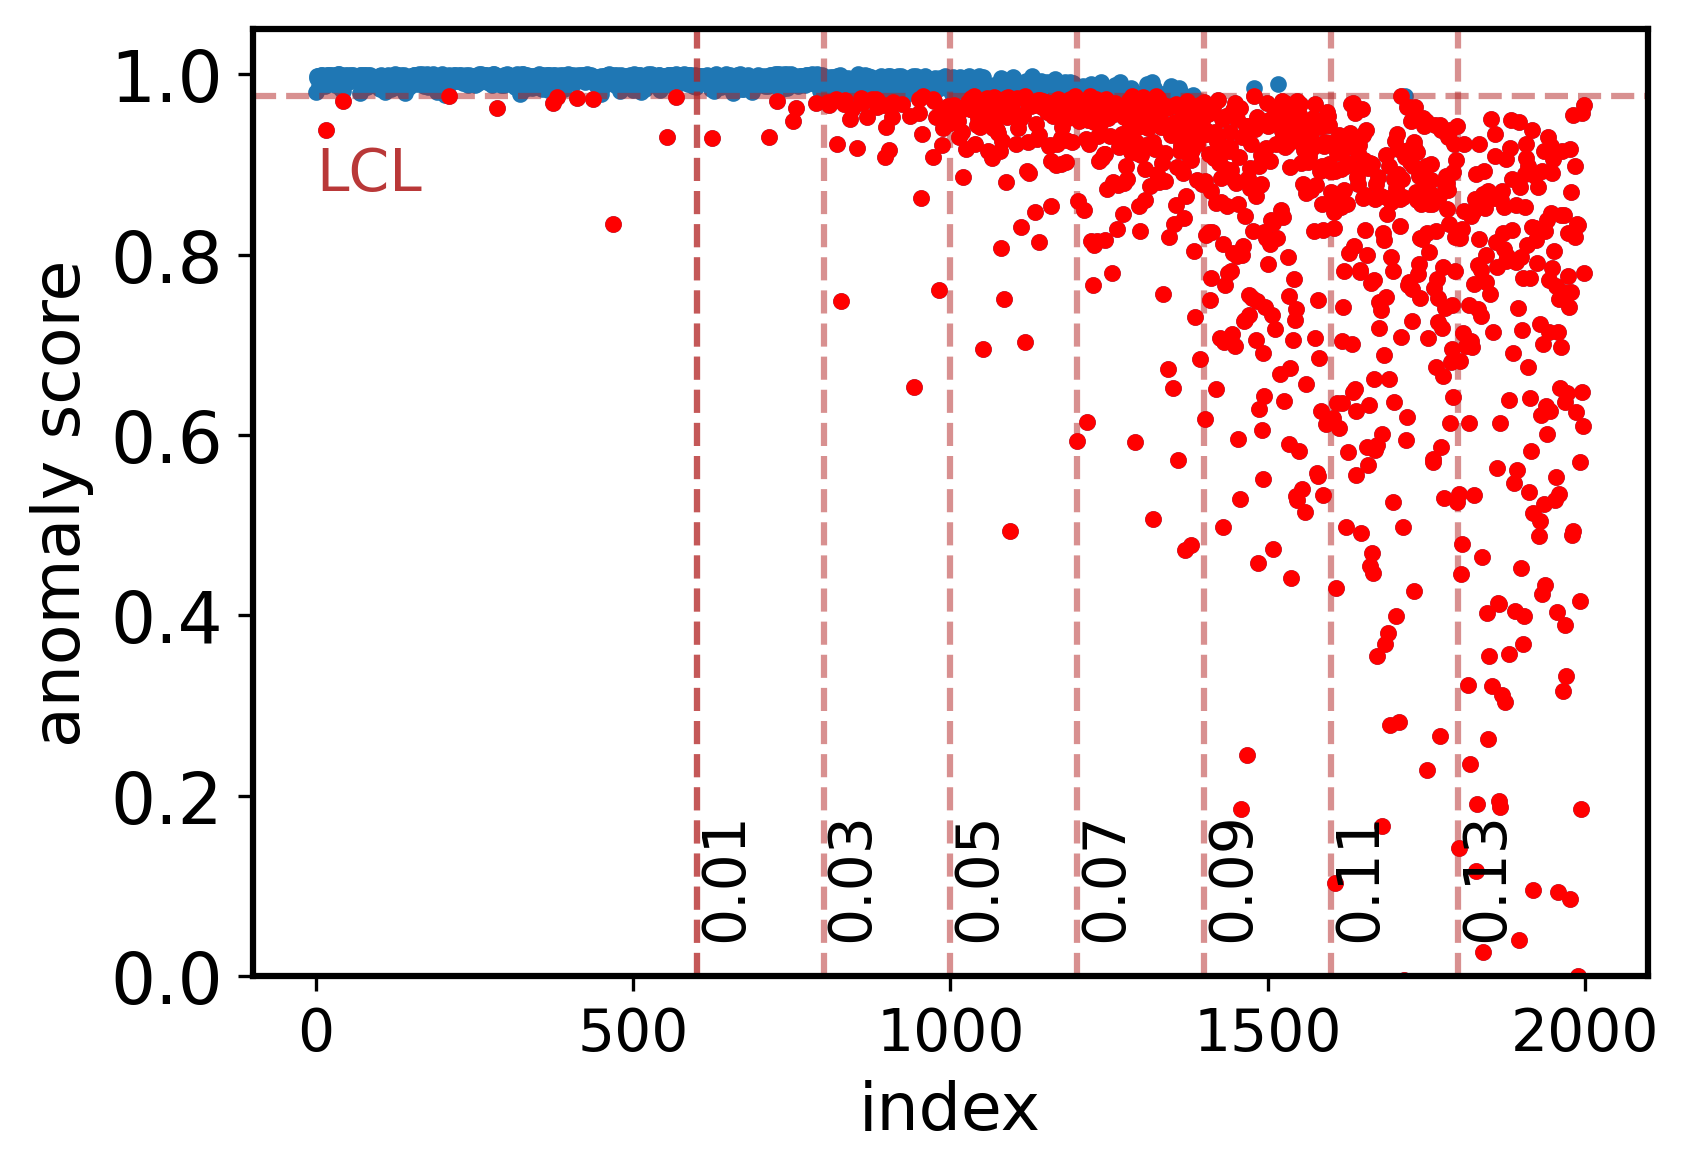

In [106]:
fig,ax= plt.subplots(figsize=(6, 4.1))
plt.ylim(0,1.05)
plot_control_chart(df_result,column='gmm-score',system_id='system_17',ax=ax)
plt.ylabel('anomaly score')
plt.title(label='')
fig.savefig('gmm_score_system_1.png',dpi=300,bbox_inches='tight')


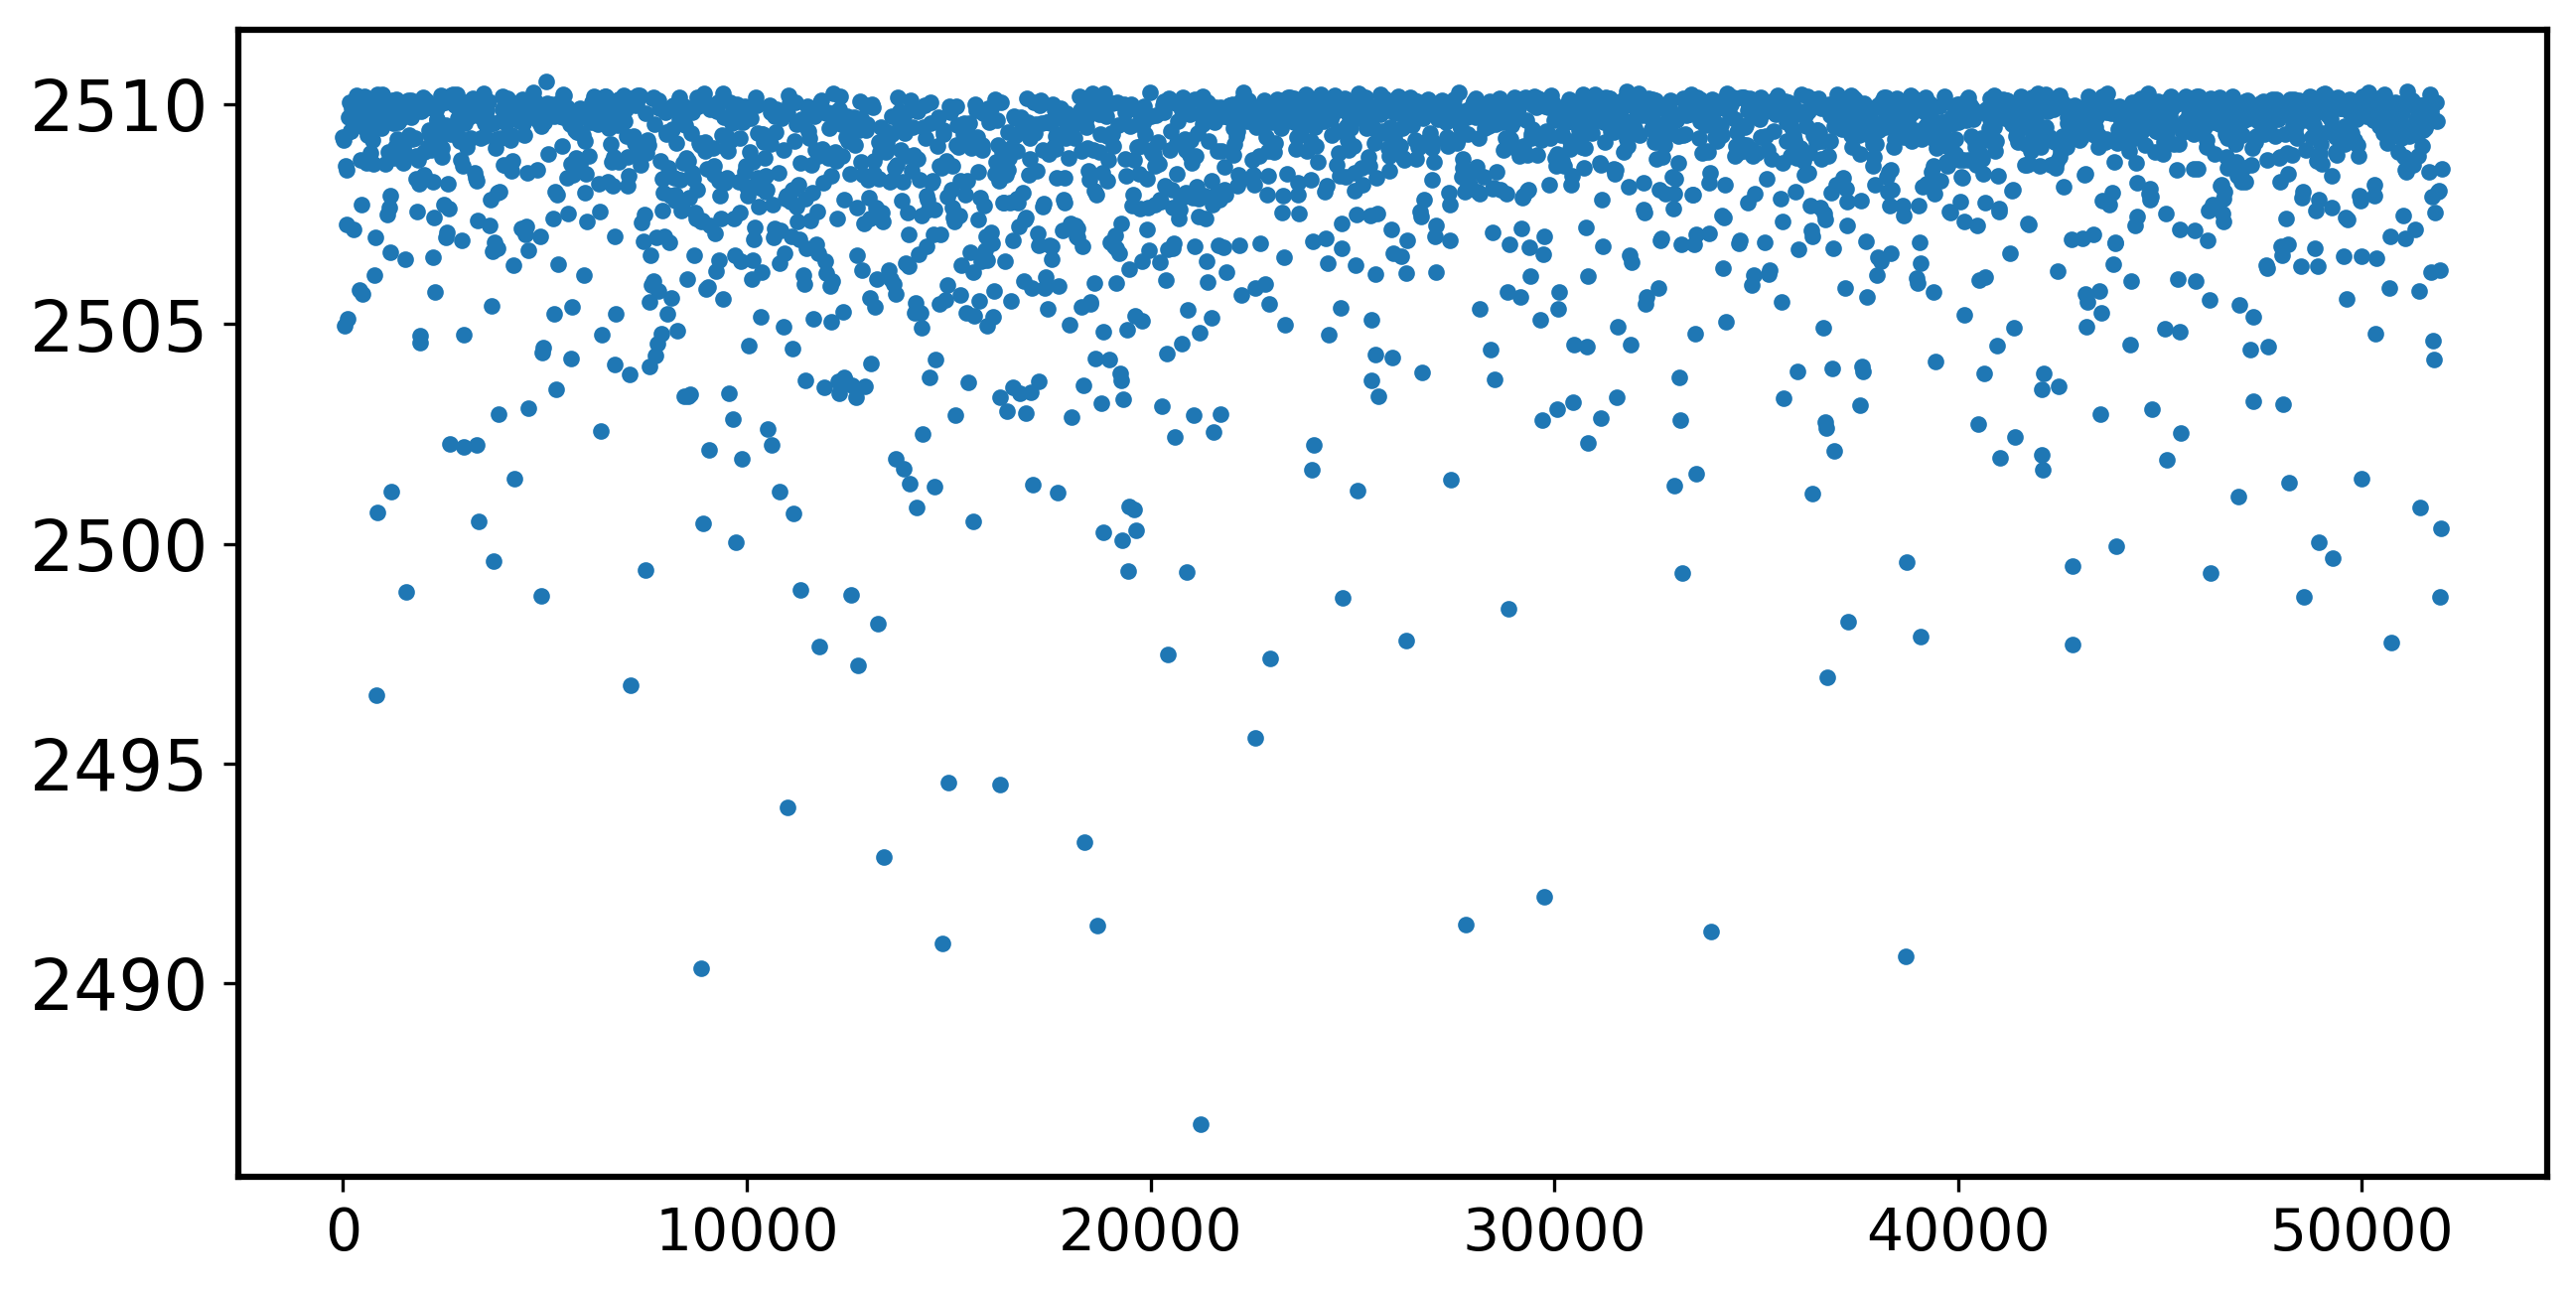

In [353]:
def arrange_control_chart_data(df, system_id, column='confidence'):
    data_system = df[df['system_name'] == system_id]
    df_train = data_system[data_system['type'] == 'train']
    df_test = data_system[data_system['type'] == 'test']
    df_test = df_test.sort_values(by='anomaly_level', ascending=True)
    df_plot = pd.concat([df_train, df_test])
    df_plot.reset_index(inplace=True)
    return df_plot, df_train, len(df_train)


In [360]:
df_plot,df_train,train_len = arrange_control_chart_data(df_result,system_id='system_10',column='gmm-score')

In [361]:
#normalize the data
df_plot['gmm-score'] = (df_plot['gmm-score'] - df_plot['gmm-score'].min())/(df_plot['gmm-score'].max()-df_plot['gmm-score'].min())

In [362]:
def plot_control_chart(df_plot, df_train, train_len, column='confidence', ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
        
    ax.plot(df_plot.index, df_plot[column], marker='.', linestyle='')

    anomaly_level = df_plot[df_plot['anomaly_level'].astype(float).diff()!=0]['anomaly_level'].to_dict()
    y_lowbound, y_upbound= ax.get_ylim()
    middle = (y_lowbound + y_upbound) / 2
    range = (y_upbound - y_lowbound) / 2
    text_y = middle - range * 0.1

    ax.axvline(x=train_len, color='firebrick', linestyle='--', alpha=0.5)
    ax.text(train_len, text_y, 'test data', rotation=90, color='firebrick', alpha=0.9)

    for key in list(anomaly_level.keys())[1:]:
        ax.axvline(x=key, color='firebrick', linestyle='--', alpha=0.5)
        ax.text(key, text_y, anomaly_level[key], color='black', alpha=1,rotation=90)

    mean = np.mean(df_train[column])
    std = np.std(df_train[column])
    lcl = mean - 2 * std
    ax.plot()
    ax.axhline(y=lcl, color='firebrick', linestyle='--', alpha=0.5)
    ax.text(0, lcl-0.1*range, 'LCL', rotation=0, color='firebrick', alpha=0.9)

    allert_df = df_plot[df_plot[column] < lcl]
    ax.plot(allert_df.index, allert_df[column], marker='.', linestyle='', color='red')

    ax.set_ylabel(column)
    ax.set_xlabel('index')
    ax.set_title(system_id)

    return fig, ax


<AxesSubplot: >

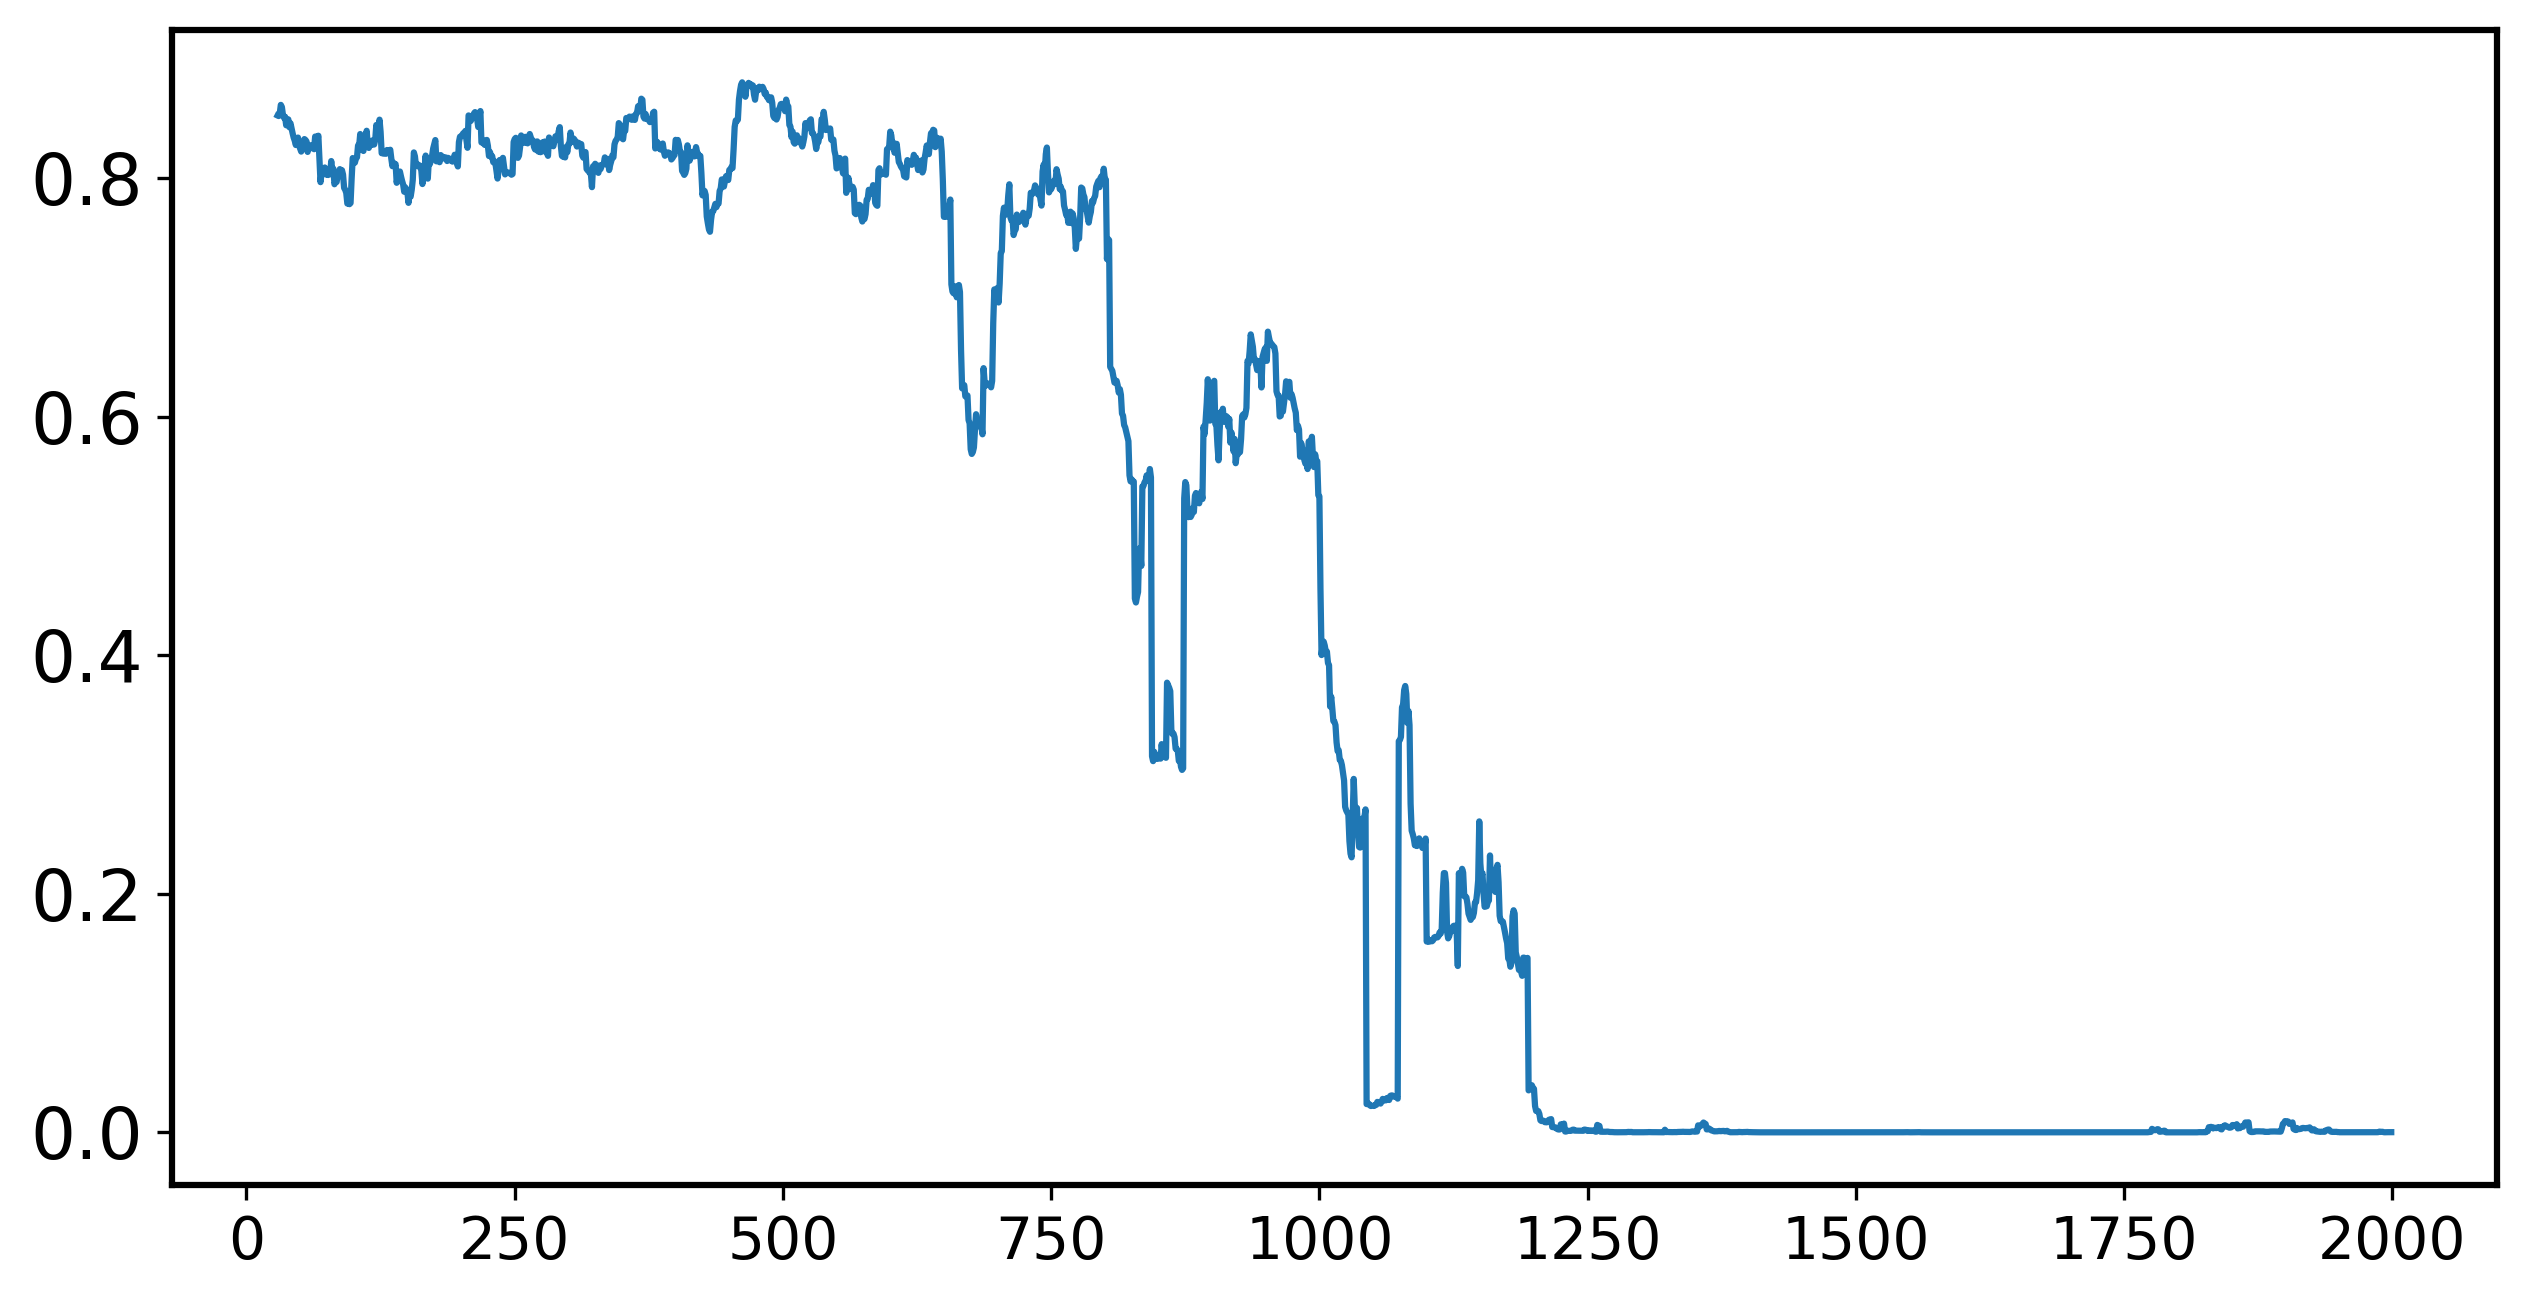

In [366]:
plt.figure(figsize=(10,5))
df_plot['gmm-score'].rolling(30).apply(lambda x: np.prod(x)).plot()